In [1]:
from ogb.graphproppred import PygGraphPropPredDataset
from ogb.graphproppred import Evaluator

import torch
from torch import nn
from torch import Tensor
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torch_geometric.data as pyg_data
from torch_geometric.data import DataLoader
from torch_geometric.data import DataListLoader
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)
print(torch.__version__)

torch.use_deterministic_algorithms(False)
torch.manual_seed(0)
modelPath = "BestMolhivPredGraphe.mdl"

Device available for running: 
cuda
1.10.1


### Load Dataset

In [3]:
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/')
split_idx = dataset.get_idx_split()
train = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True)
dev = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False)
test = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False)

/home/master/mia2004/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Train GIN Model

In [24]:
evaluator = Evaluator(name = "ogbg-molhiv")
model = pyg_nn.GIN(in_channels= 9, hidden_channels= 32, out_channels = 1, num_layers= 5, dropout = 0.5)
model = model.to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

bestDevScore = -1
devScore=[]
losstab=[]

for epoch in range(150):
        
        #Train Model        
        model.train()
        for batch in train:
            opt.zero_grad()
            x,edge_index,batchb = batch.x.float().to(device),batch.edge_index.to(device),batch.batch.to(device)
            pred = pyg_nn.global_mean_pool(model(x,edge_index), batchb)
            label = batch.y.float().to(device)
            loss = loss_fn(pred,label)
            loss.backward()
            opt.step()
        losstab.append(loss)
        
        #Evaluate on dev
        model.eval()
        devpred = Tensor().to(device)
        devlabel = Tensor().to(device)
        for batch in dev:
            x,edge_index,batchb = batch.x.float().to(device),batch.edge_index.to(device),batch.batch.to(device)
            pred = pyg_nn.global_mean_pool(model(x,edge_index), batchb)
            label = batch.y.float().to(device)
            devpred = torch.cat((devpred,pred),0)
            devlabel = torch.cat((devlabel,label),0)
#             print(pred.shape,label.shape,devpred.shape,devlabel.shape)
        result_dict = evaluator.eval({"y_true": devlabel, "y_pred": devpred})
        devScore.append(result_dict['rocauc'])
        if bestDevScore < result_dict['rocauc']:
            bestDevScore = result_dict['rocauc']
            torch.save(model.state_dict(),modelPath)
            
        if epoch % 10 == 0:
            print(epoch,": ", result_dict)
     
     

tensor(0.1997, device='cuda:0', grad_fn=<MseLossBackward0>)
total_loss:  0.037653167674448505
0 :  {'rocauc': 0.6461716759749168}
total_loss:  0.0339854528422653
10 :  {'rocauc': 0.6974788114834412}
total_loss:  0.03320711195975708
20 :  {'rocauc': 0.7430325911228688}
total_loss:  0.03254783583843193
30 :  {'rocauc': 0.760923415147952}
total_loss:  0.0322890825052917
40 :  {'rocauc': 0.7069769008426416}
total_loss:  0.03223064214130986
50 :  {'rocauc': 0.7536146017048794}
total_loss:  0.03181432740096728
60 :  {'rocauc': 0.7552083333333333}
total_loss:  0.03150887029657933
70 :  {'rocauc': 0.7347730501665686}
total_loss:  0.03156712537394238
80 :  {'rocauc': 0.7036761463844798}
total_loss:  0.03154280638595508
90 :  {'rocauc': 0.6397477586713698}
total_loss:  0.031280589541007556
100 :  {'rocauc': 0.6987816602978638}
total_loss:  0.03132693228340398
110 :  {'rocauc': 0.7030790711346266}
total_loss:  0.031190918027840953
120 :  {'rocauc': 0.7342157799333724}
total_loss:  0.0310087123188

### Visualize dev score evolution

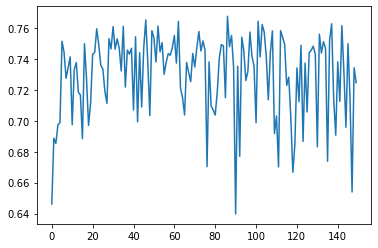

In [25]:
plt.plot(devScore)

### Evaluate on dev and train dataset

In [31]:
model = pyg_nn.GIN(in_channels= 9, hidden_channels= 32, out_channels = 1, num_layers= 5, dropout = 0.5)
model.load_state_dict(torch.load(modelPath))
model = model.to(device)

model.eval()
devpred = Tensor().to(device)
devlabel = Tensor().to(device)
for batch in dev:
    x,edge_index,batchb = batch.x.float().to(device),batch.edge_index.to(device),batch.batch.to(device)
    pred = pyg_nn.global_mean_pool(model(x,edge_index), batchb)
    label = batch.y.float().to(device)
    devpred = torch.cat((devpred,pred),0)
    devlabel = torch.cat((devlabel,label),0)
#             print(pred.shape,label.shape,devpred.shape,devlabel.shape)
result_dict = evaluator.eval({"y_true": devlabel, "y_pred": devpred})

print("Dev score:", result_dict["rocauc"])

testpred = Tensor().to(device)
testlabel = Tensor().to(device)
for batch in test:
    x,edge_index,batchb = batch.x.float().to(device),batch.edge_index.to(device),batch.batch.to(device)
    pred = pyg_nn.global_mean_pool(model(x,edge_index), batchb)
    label = batch.y.float().to(device)
    testpred = torch.cat((testpred,pred),0)
    testlabel = torch.cat((testlabel,label),0)
#             print(pred.shape,label.shape,devpred.shape,devlabel.shape)
result_dict = evaluator.eval({"y_true": testlabel, "y_pred": testpred})

print("Test score:", result_dict["rocauc"])

Dev score: 0.767636684303351
Test score: 0.7402943278162961
